In [6]:
import numpy as np
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from scipy.stats import binom

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

## Exercises Ch 4:

### Exercise 1: 

In Major League Baseball, most players have a batting average between .200 and .330, which means that their probability of getting a hit is between 0.2 and 0.33.

Suppose a player appearing in their first game gets 3 hits out of 3 attempts. What is the posterior distribution for their probability of getting a hit?

For this exercise, I’ll construct the prior distribution by starting with a uniform distribution and updating it with imaginary data until it has a shape that reflects my background knowledge of batting averages.


In [10]:
# Constructing a reasonable Prior
# uniform prior
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

# likelihoods
lk = {'Y': hypos,
      'N': 1 - hypos}

# data (random)
dataset = 'Y' * 25 + 'N' * 75

# update:
for data in dataset:
    prior *= lk[data]

prior.normalize()

1.3596964206970507e-23

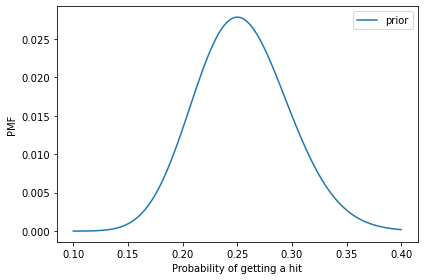

In [12]:
prior.plot(label='prior')
decorate(xlabel='Probability of getting a hit',
         ylabel='PMF');

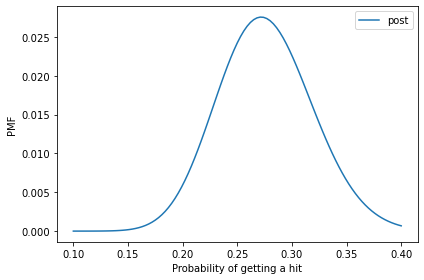

In [13]:
# update:
dataset = 'YYY'
post = prior.copy()

for data in dataset:
    post *= lk[data]

post.normalize()

post.plot(label='post')
decorate(xlabel='Probability of getting a hit',
         ylabel='PMF');

In [15]:
# we can note the shift in max_prob from prior -> post
# makes sense given we have data showing all hits
# however, prior dist still playing a huge role
print(prior.max_prob())
print(post.max_prob())

0.25
0.271


### Exercise 2:

Exercise: Whenever you survey people about sensitive issues, you have to deal with social desirability bias, which is the tendency of people to adjust their answers to show themselves in the most positive light. One way to improve the accuracy of the results is randomized response.

As an example, suppose you want to know how many people cheat on their taxes. If you ask them directly, it is likely that some of the cheaters will lie. You can get a more accurate estimate if you ask them indirectly, like this: Ask each person to flip a coin and, without revealing the outcome,

- If they get heads, they report YES.

- If they get tails, they honestly answer the question “Do you cheat on your taxes?”

If someone says YES, we don’t know whether they actually cheat on their taxes; they might have flipped heads. Knowing this, people might be more willing to answer honestly.

Suppose you survey 100 people this way and get 80 YESes and 20 NOs. Based on this data, what is the posterior distribution for the fraction of people who cheat on their taxes? What is the most likely quantity in the posterior distribution?

In [18]:
# we just assume any distribution of tax fraud is likely
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

If our actual fraction of cheaters is `0.4` then we'd expect the following for Yes:

- (0.5 * 0.4) = 0.2 of our True yes identify
- (0.5 * 1) = 0.5 of our total say yes
- Overall 0.7

Can convert to: $0.5 * (1 + x)$

Or no: $0.5 * (1 - x)$


In [19]:
# likelihoods
lk = {'Y': 0.5 * (1 + hypos),
    'N': 0.5 * (1-hypos)}

# data (random)
dataset = 'Y' * 80 + 'N' * 20

# update:
for data in dataset:
    prior *= lk[data]

prior.normalize()

3.6945139133967024e-21

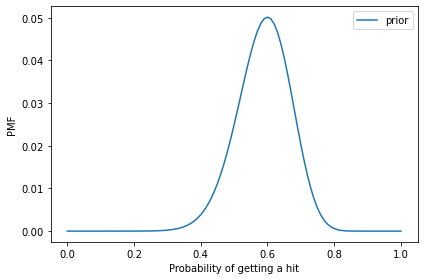

In [22]:
prior.plot(label='prior')
decorate(xlabel='Probability of getting a hit',
         ylabel='PMF');

In [24]:
prior.max_prob()

0.6